# Recommender Dataset

In this analysis, we use the MovieLens dataset, as described in Harper and Konstan (2015). It consists of:
- 100,000 ratings (1-5) from 943 users on 1682 movies

- Each user has rated at least 20 movies

- Simple demographic info for the users (age, gender, occupation, zip)

## Review of the files

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from concurrent.futures import ThreadPoolExecutor
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error

### Ratings (u.data)
Information about which user rated which movie with what rating.

In [94]:
ratings_df = pd.read_csv('data/ml-100k/u.data', sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
ratings_df['timestamp'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

In [95]:
ratings_df.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


In [96]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    100000 non-null  int64         
 1   movie_id   100000 non-null  int64         
 2   rating     100000 non-null  int64         
 3   timestamp  100000 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 3.1 MB


There are no missing values for the ratings.

### Movies: (u.item)
Extensive information about each movie.

In [97]:
movie_columns = ['movie_id', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action',
                 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_df = pd.read_csv('data/ml-100k/u.item', sep='|', names=movie_columns, encoding='latin-1')

In [98]:
movies_df.head()

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [99]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   movie_title         1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   unknown             1682 non-null   int64  
 6   Action              1682 non-null   int64  
 7   Adventure           1682 non-null   int64  
 8   Animation           1682 non-null   int64  
 9   Children's          1682 non-null   int64  
 10  Comedy              1682 non-null   int64  
 11  Crime               1682 non-null   int64  
 12  Documentary         1682 non-null   int64  
 13  Drama               1682 non-null   int64  
 14  Fantasy             1682 non-null   int64  
 15  Film-Noir           1682 non-null   int64  
 16  Horror

**video_release_date** seems to be completely missing, so we can immediately drop the feature.

Two values for **ImDb_URL** are missing. This is not a problem since the feature does not have any value for the prediction and we will drop it later.

One value for **release_date** is missing.


In [100]:
movies_df[movies_df['release_date'].isna()]

,movie_id,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
266,267,unknown,NaN,NaN,NaN,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
ratings_df[ratings_df['movie_id'] == 267]

,user_id,movie_id,rating,timestamp
2172,130,267,5,1997-10-02 14:07:19
3781,5,267,4,1997-09-30 15:57:44
7245,268,267,3,1997-10-01 21:41:17
12475,297,267,3,1997-09-28 01:12:19
14756,319,267,4,1997-10-01 12:08:10
15292,1,267,4,1997-10-01 08:02:35
49295,532,267,3,1997-09-28 10:09:08
93523,833,267,1,1997-09-30 21:41:09
99723,422,267,4,1997-09-30 21:46:26


In [102]:
movies_df = movies_df[movies_df['movie_id'] != 267]
ratings_df = ratings_df[ratings_df['movie_id'] != 267]

Since there is absolutely no information about the movie 267, we just manually drop it and the 9 corresponding ratings.

### Users (u.user)
Demographic information about each user.

In [103]:
users_df = pd.read_csv('data/ml-100k/u.user', sep='|', names=['user_id', 'age', 'gender', 'occupation', 'zip_code'])

In [104]:
users_df.head()

,user_id,age,gender,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [105]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 943 entries, 0 to 942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     943 non-null    int64 
 1   age         943 non-null    int64 
 2   gender      943 non-null    object
 3   occupation  943 non-null    object
 4   zip_code    943 non-null    object
dtypes: int64(2), object(3)
memory usage: 37.0+ KB


There are no missing values for the users.

## Exploratory Data Analysis (EDA)

### Distribution of Ratings

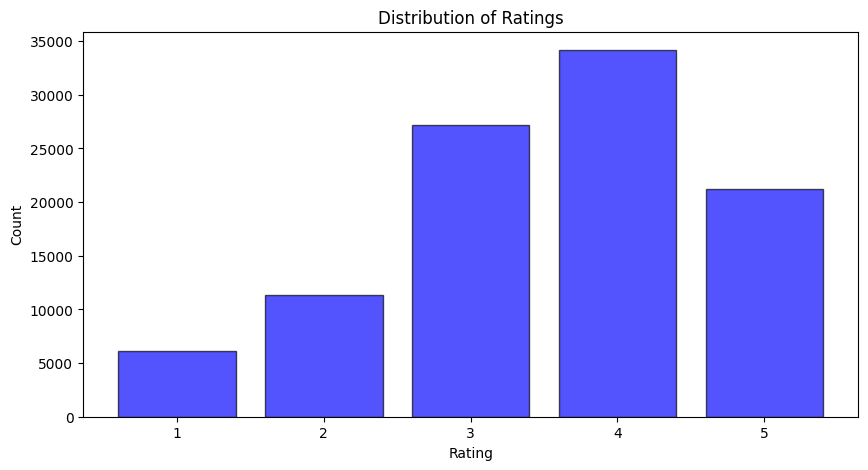

In [106]:
plt.figure(figsize=(10, 5))
ratings_count = ratings_df['rating'].value_counts().sort_index()
plt.bar(ratings_count.index, ratings_count.values, color='blue', alpha=0.67, edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The distribution of ratings shows a strong bias toward higher scores, with users favoring good ratings over bad ones. This highlights a positivity bias in the dataset, which could challenge the model's ability to differentiate content quality.

### Number of Ratings per User

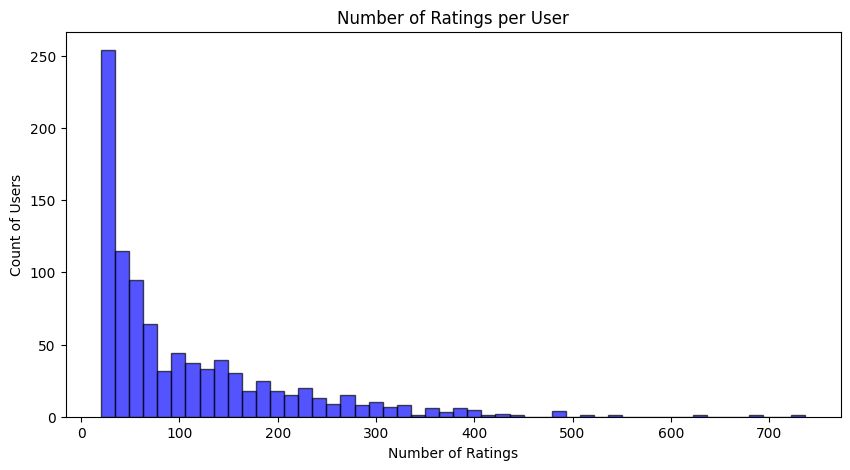

In [107]:
plt.figure(figsize=(10, 5))
plt.hist(ratings_df['user_id'].value_counts(), bins=50, color='blue', alpha=0.67, edgecolor='black')
plt.title('Number of Ratings per User')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Users')
plt.show()

The histogram of ratings per user shows that most users rated fewer than 50 movies, while only a small fraction rated more than 300. This indicates a sparse user-item interaction matrix.

### Number of Ratings per Movie

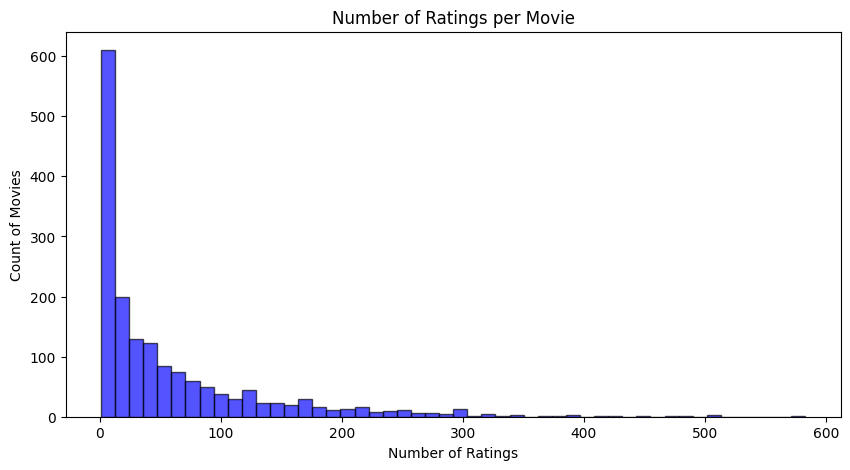

In [108]:
plt.figure(figsize=(10, 5))
plt.hist(ratings_df['movie_id'].value_counts(), bins=50, color='blue', alpha=0.67, edgecolor='black')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count of Movies')
plt.show()

The analysis of ratings per movie shows that most movies have very few ratings, while a small number of popular titles dominate with over 200 ratings. This imbalance could result in popular movies disproportionately influencing the predictions.

### User Age Distribution

TODO Add Boxplot

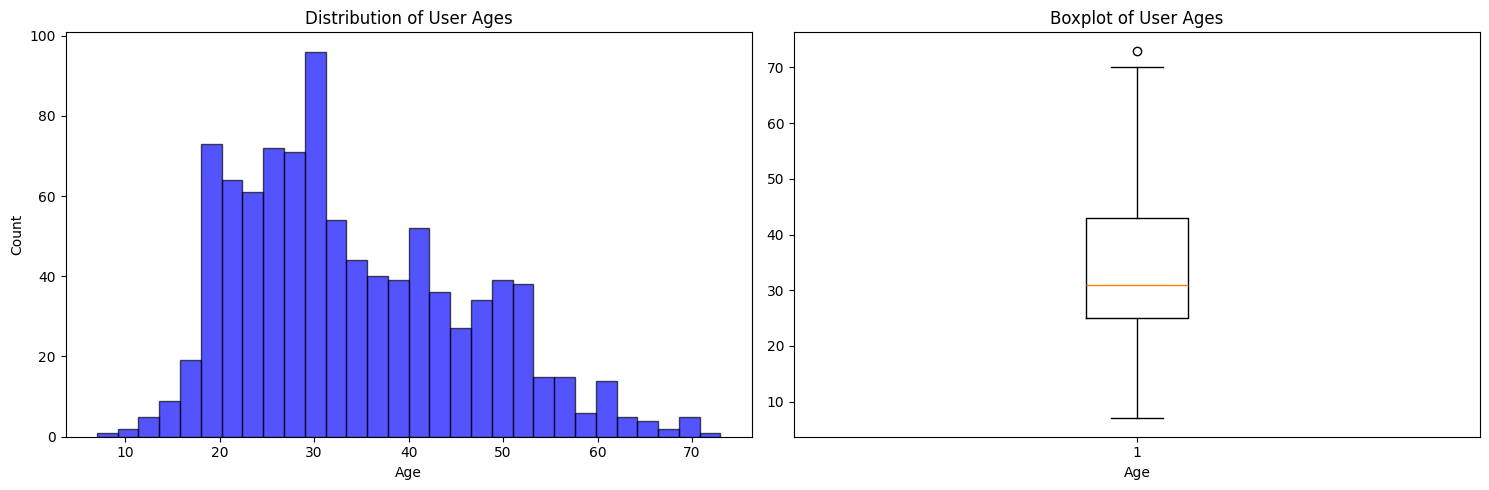

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(users_df['age'], bins=30, color='blue', alpha=0.67, edgecolor='black')
axes[0].set_title('Distribution of User Ages')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

axes[1].boxplot(users_df['age'])
axes[1].set_title('Boxplot of User Ages')
axes[1].set_xlabel('Age')

plt.tight_layout()
plt.show()

The age distribution of users shows a concentration around the 20-30 age range, with a median age slightly above 30. The boxplot highlights this central tendency, while the presence of a small subset of older users may contribute to unique preferences.

### Gender Distribution

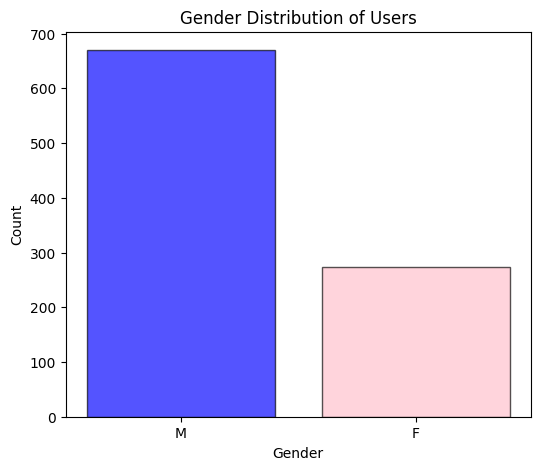

In [110]:
plt.figure(figsize=(6, 5))
gender_count = users_df['gender'].value_counts()
plt.bar(gender_count.index, gender_count.values, color=['blue', 'pink'], alpha=0.67, edgecolor='black')
plt.title('Gender Distribution of Users')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

The gender distribution shows that male users significantly outnumber females, by more than a two-to-one ratio. This imbalance might skew the model’s recommendations.

### Occupation Distribution

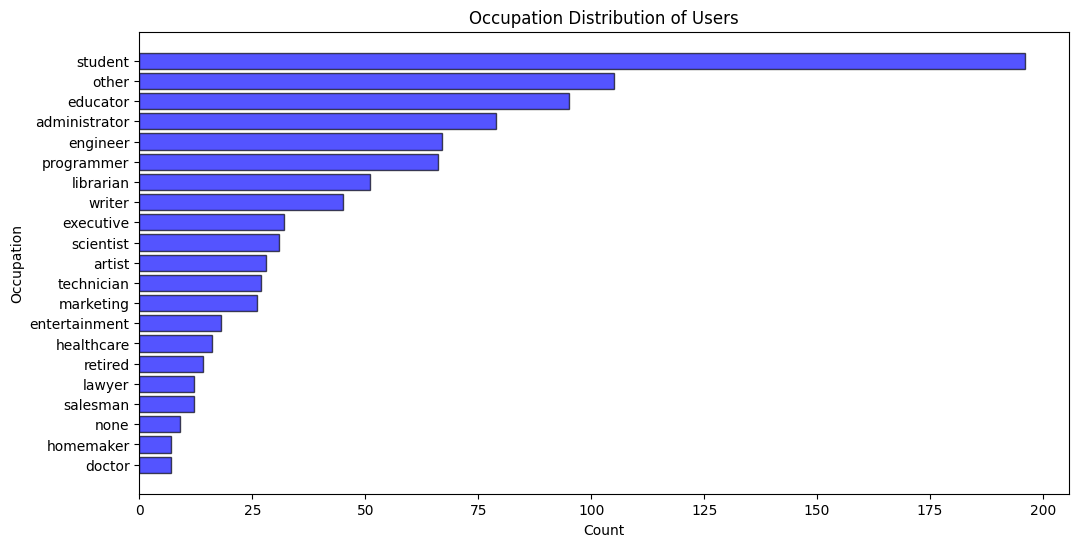

In [111]:
plt.figure(figsize=(12, 6))
occupation_count = users_df['occupation'].value_counts().sort_values(ascending=True)
plt.barh(occupation_count.index, occupation_count.values, color='blue', alpha=0.67, edgecolor='black')
plt.title('Occupation Distribution of Users')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

The occupation distribution highlights students as the largest group, followed by a general "other" category. This suggests that the dataset may be more representative of a younger, academical userbase.

### Popular Movie Genres

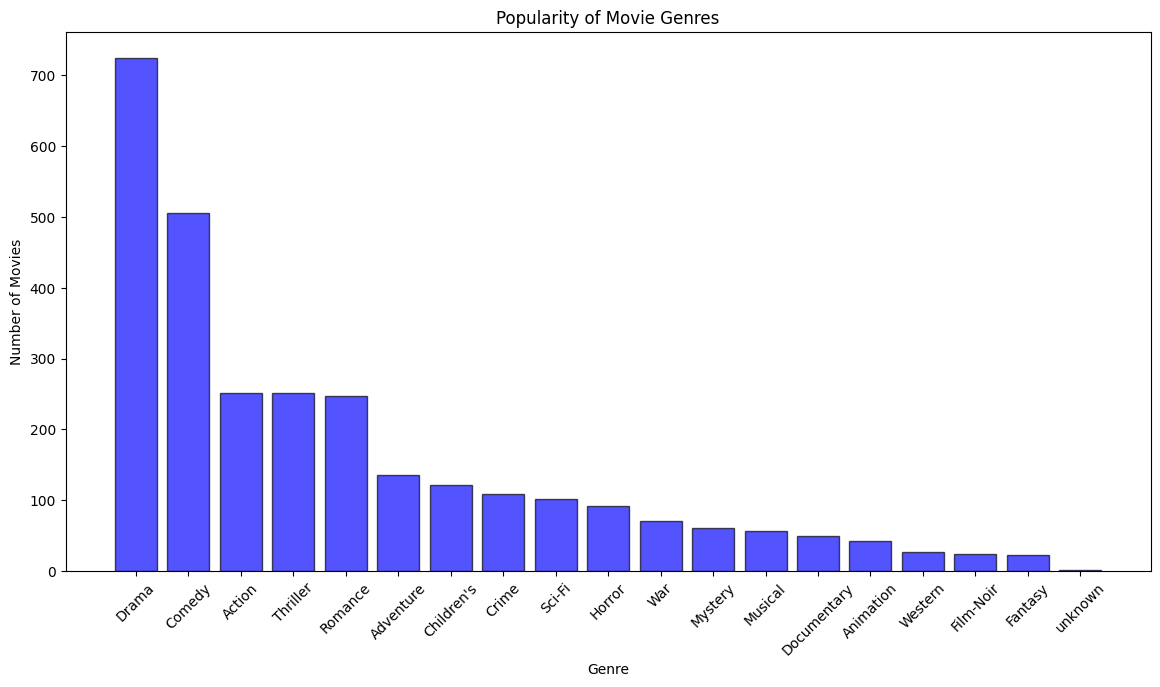

In [112]:
genre_columns = movie_columns[5:]
genre_totals = movies_df[genre_columns].sum().sort_values(ascending=False)

plt.figure(figsize=(14, 7))
plt.bar(genre_totals.index, genre_totals.values, color='blue', alpha=0.67, edgecolor='black')
plt.title('Popularity of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

The genre analysis reveals that drama and comedy are the most popular categories by a lot. This dominance could lead to overrepresentation in recommendations.

### Genre Preferences by Age Group

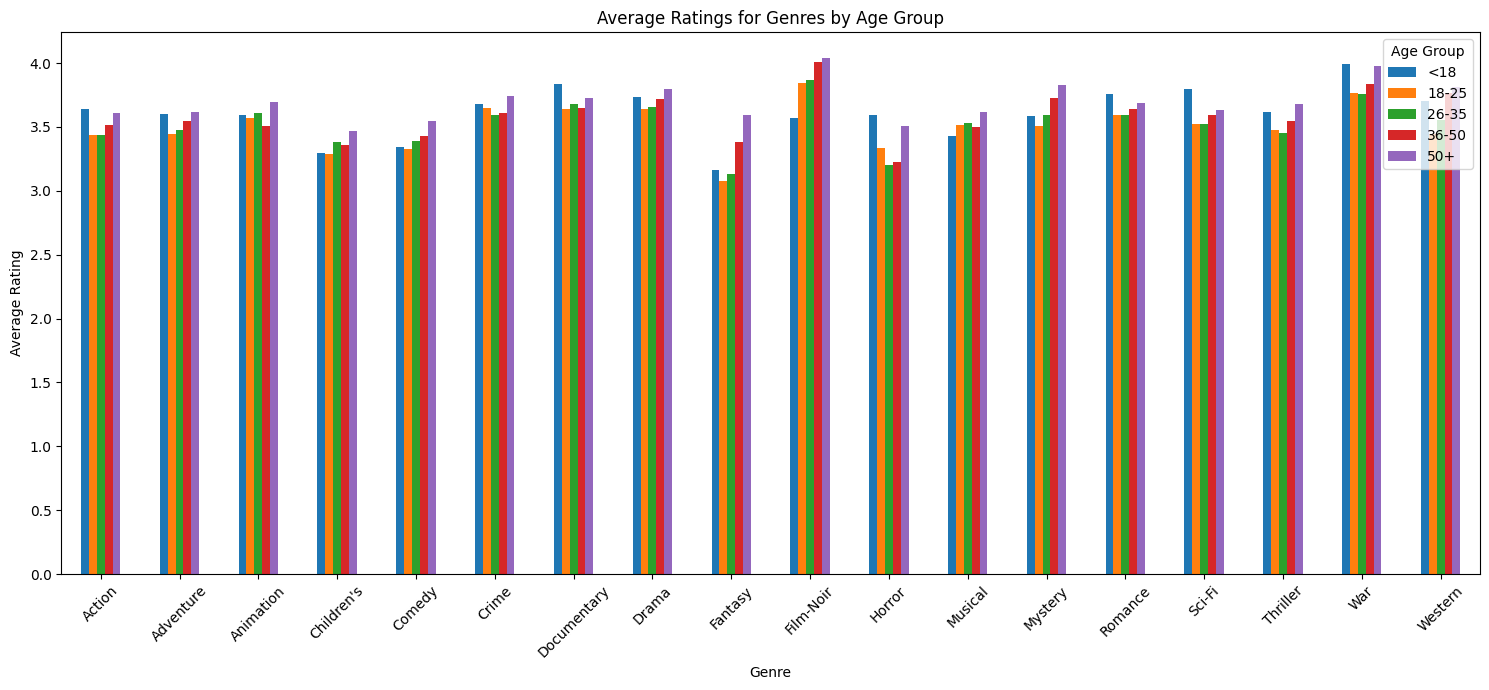

In [113]:
merged_df = pd.merge(pd.merge(ratings_df, users_df, on='user_id'), movies_df, on='movie_id')

merged_df['age_group'] = pd.cut(merged_df['age'], bins=[0, 18, 25, 35, 50, 100],
                                labels=['<18', '18-25', '26-35', '36-50', '50+'])

genre_columns = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary',
                 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
                 'Thriller', 'War', 'Western']

genre_age_ratings = {}
for genre in genre_columns:
    genre_age_ratings[genre] = merged_df.groupby('age_group', group_keys=False, observed=False).apply(
        lambda x: (x['rating'] * x[genre]).sum() / x[genre].sum() if x[genre].sum() > 0 else 0,
        include_groups=False
    )

genre_age_ratings = pd.DataFrame(genre_age_ratings)

genre_age_ratings.T.plot(kind='bar', figsize=(15, 7))
plt.title('Average Ratings for Genres by Age Group')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.legend(title='Age Group')
plt.tight_layout()
plt.show()

Film-Noir and Fantasy show a trend where older users give higher ratings. Fantasy and Horror are ranked the lowest across most groups. For most genres, the youngest (<18) and oldest (50+) age groups give the best ratings.

### Ratings Based on Movie Age

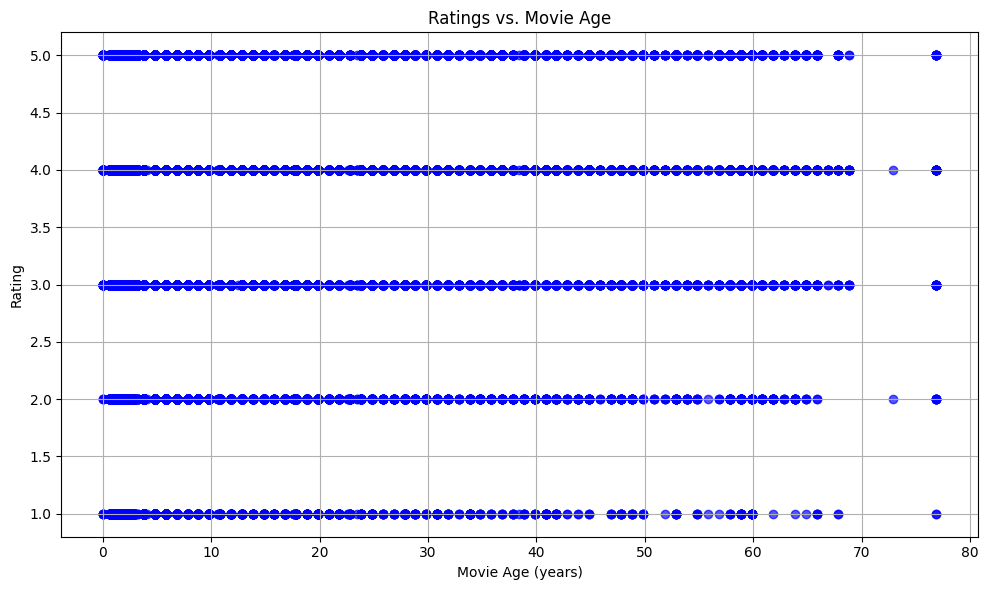

Correlation between movie age and ratings: 0.17


In [114]:
merged_df['release_date'] = pd.to_datetime(merged_df['release_date'], format='%d-%b-%Y')

merged_df['movie_age'] = (merged_df['release_date'].max() - merged_df['release_date']).dt.days / 365

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['movie_age'], merged_df['rating'], color='blue', alpha=0.67)
plt.xlabel('Movie Age (years)')
plt.ylabel('Rating')
plt.title('Ratings vs. Movie Age')
plt.grid()
plt.tight_layout()
plt.show()

correlation = merged_df[['movie_age', 'rating']].corr().iloc[0, 1]
print(f"Correlation between movie age and ratings: {correlation:.2f}")


The correlation between movie age and ratings is 0.17, showing a slight tendency for older movies to receive higher ratings. This can help refine recommendations for users with preferences for old or newer movies.

### Geographic Trends in Ratings (Zip Codes)

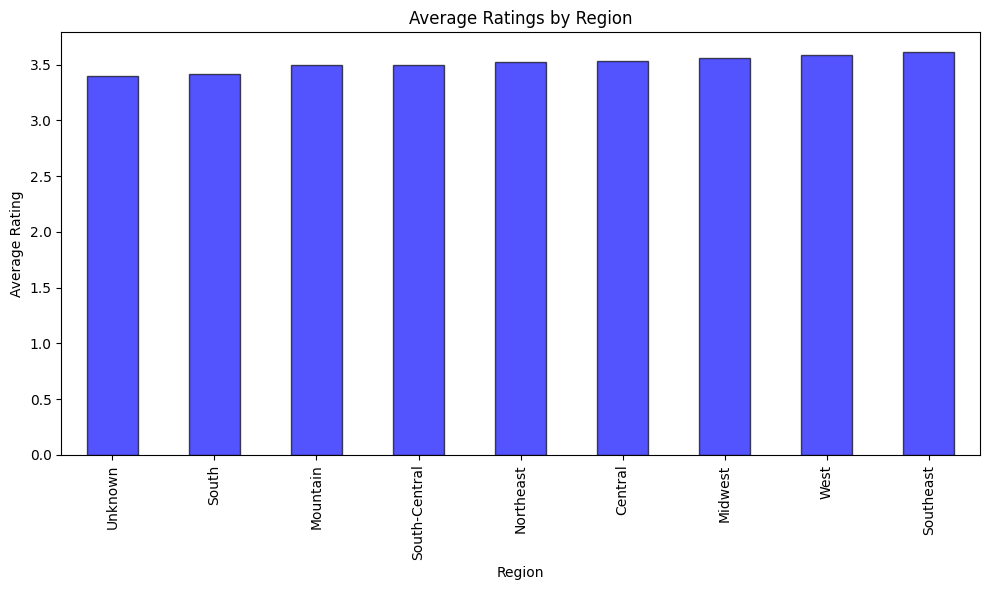

In [115]:
merged_df = pd.merge(pd.merge(ratings_df, users_df, on='user_id'), movies_df, on='movie_id')


def group_zip_code(zip_code):
    if pd.isna(zip_code):
        return 'Unknown'
    first_digit = str(zip_code)[0]
    region_map = {
        '0': 'Northeast',
        '1': 'Northeast',
        '2': 'South',
        '3': 'Southeast',
        '4': 'Midwest',
        '5': 'Midwest',
        '6': 'Central',
        '7': 'South-Central',
        '8': 'Mountain',
        '9': 'West'
    }
    return region_map.get(first_digit, 'Unknown')


merged_df['region'] = merged_df['zip_code'].apply(group_zip_code)

region_ratings = merged_df.groupby('region')['rating'].mean()
region_counts = merged_df['region'].value_counts()

valid_regions = region_counts[region_counts > 50].index
region_ratings_filtered = region_ratings[region_ratings.index.isin(valid_regions)]

plt.figure(figsize=(10, 6))
region_ratings_filtered.sort_values().plot(kind='bar', color='blue', alpha=0.67, edgecolor='black')
plt.title('Average Ratings by Region')
plt.xlabel('Region')
plt.ylabel('Average Rating')
plt.tight_layout()
plt.show()

We assume these are american zip codes and group them by the first digit (https://www.unitedstateszipcodes.org/). The average ratings across regions show almost no variation, indicating little to no correlation between geographic location and movie ratings. This suggests that regional factors may not play a significant role in user preferences.

## Summary of the Analysis

The dataset has a strong positivity bias in ratings, as users mostly give higher scores. Most users rated fewer than 50 movies, and only a few rated more than 300, showing a sparse interaction matrix. Similarly, most movies received very few ratings, with a small group of popular films dominating. The user demographic is younger, with a median age slightly above 30, and more male users than female. Students make up the largest occupation group, and drama and comedy are the most common genres. These patterns highlight biases and sparsity in the data.

Furthermore, we analyzed some correlations: older users rate Film-Noir and Fantasy higher, while Fantasy and Horror get the lowest ratings overall. Younger (<18) and older (50+) users often give higher scores than others. A weak correlation (0.17) shows older movies get slightly higher ratings. Geographic location, based on American zip code groups, shows no clear influence on ratings.

# Basic Matrix Factorization (MF)

## Implementation of MF

The `MatrixFactorizationSGD` model applies matrix factorization to learn. Each user $u$ and item $i$ are represented by vectors:

$$
p_u, q_i \in \mathbb{R}^f
$$

**Rating Prediction**:

The model predicts user ratings based on the global average $ \mu $, user and item biases $ b_u, b_i $, and the interaction between users and items:

$$
\hat{r}_{ui} = \mu + b_u + b_i + p_u^T q_i
$$

**Loss Function**:

The objective is to minimize the regularized squared error between predicted and actual ratings:

$$
\min_{p_u, q_i} \sum_{(u,i) \in \kappa} (r_{ui} - \hat{r}_{ui})^2 + \lambda (||p_u||^2 + ||q_i||^2)
$$

**SGD Updates**:

For each rating, the error is computed and used to update the factors and biases:

$$
e_{ui} = r_{ui} - \hat{r}_{ui}
$$

The learning rate is dynamically adjusted using **Bold Driver**.



In [116]:
class MatrixFactorizationSGD:
    def __init__(self, num_factors=10, learning_rate=0.01, reg_param=0.01, max_epochs=200, tolerance=1e-5):
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.reg_param = reg_param
        self.max_epochs = max_epochs
        self.tolerance = tolerance
        self.P = None
        self.Q = None
        self.user_bias = None
        self.item_bias = None
        self.global_bias = None

    def fit(self, ratings):
        """
        Fits the matrix factorization model to the given ratings matrix using Stochastic Gradient Descent (SGD).
        :param ratings: A matrix of user-item ratings where rows represent users and columns represent items.
        :return: A list containing the loss history during the training process.
        """
        n, m = ratings.shape

        self.P = np.random.normal(scale=0.1, size=(n, self.num_factors))
        self.Q = np.random.normal(scale=0.1, size=(m, self.num_factors))
        self.user_bias = np.zeros(n)
        self.item_bias = np.zeros(m)
        self.global_bias = np.mean(ratings[ratings != 0])

        loss_history = []

        for epoch in range(1, self.max_epochs + 1):
            prev_loss = self._loss(ratings)

            for u in range(n):
                for i in range(m):
                    if ratings[u][i] > 0:
                        err_ui = ratings[u, i] - self.predict(u, i)

                        self.user_bias[u] += self.learning_rate * (err_ui - self.reg_param * self.user_bias[u])
                        self.item_bias[i] += self.learning_rate * (err_ui - self.reg_param * self.item_bias[i])

                        self.P[u, :] += self.learning_rate * (err_ui * self.Q[i, :] - self.reg_param * self.P[u, :])
                        self.Q[i, :] += self.learning_rate * (err_ui * self.P[u, :] - self.reg_param * self.Q[i, :])

            current_loss = self._loss(ratings)
            loss_history.append(current_loss)
            loss_diff = abs(current_loss - prev_loss)

            # Bold Driver
            if current_loss < prev_loss:
                self.learning_rate *= 1.05
            else:
                self.learning_rate *= 0.5

            if loss_diff < self.tolerance:
                # print(f'Converged at epoch {epoch}.')
                break

        else:
            print(f'WARNING: Did not converge in {self.max_epochs} epochs.')

        return loss_history

    def predict(self, user, item):
        """
        Predicts the ratings for a user for a given item.
        :param user: User index.
        :param item: Item index.
        :return: Predicted rating.
        """
        if self.P is None or self.Q is None or self.user_bias is None or self.item_bias is None or self.global_bias is None:
            raise ValueError('Call fit before predicting!')

        return self.global_bias + self.user_bias[user] + self.item_bias[item] + self.P[user, :] @ self.Q[item, :].T

    def _loss(self, ratings):
        non_zero_pairs = np.array(ratings.nonzero()).T

        loss = 0
        for u, i in non_zero_pairs:
            loss += (ratings[u, i] - self.predict(u, i)) ** 2

        return loss / len(non_zero_pairs)

## Data Pre-Processing

First, we drop irrelevant features:

- **video_release_date** is entirely missing in the dataset

- **IMDb_URL** just adds noise to the prediction

- **unknown** genre column is redundant

- **movie_title** since the model only relies on movie_id to represent movies

- **zip_code** can be dropped, since there is no correlation according to our analysis.

In [117]:
movies_df = movies_df.drop(columns=['video_release_date', 'IMDb_URL', 'unknown', 'movie_title'])
users_df = users_df.drop(columns=['zip_code'])

n_users = ratings_df['user_id'].nunique()
n_items = ratings_df['movie_id'].max()
ratings_matrix = np.zeros((n_users, n_items))

for row in ratings_df.itertuples():
    ratings_matrix[row.user_id - 1, row.movie_id - 1] = row.rating

scaler = MinMaxScaler()
ratings_matrix_normalized = scaler.fit_transform(ratings_matrix)

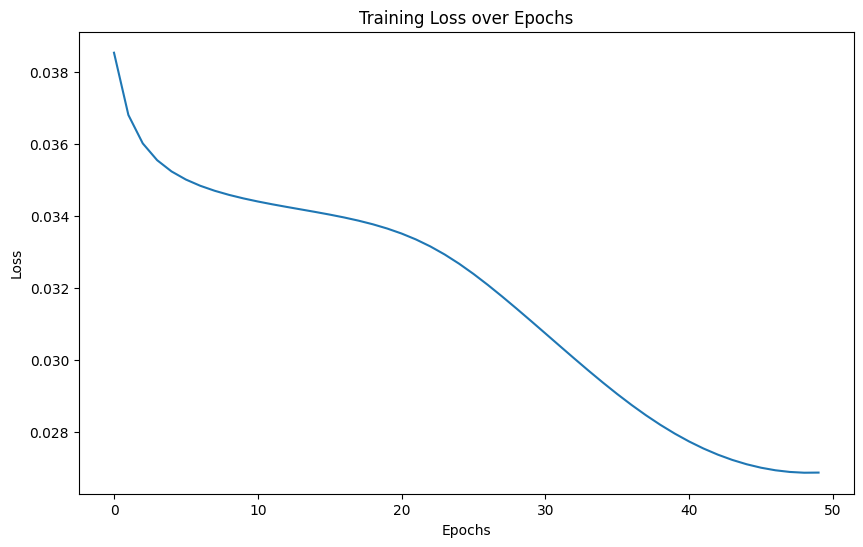

In [118]:
mf_sgd = MatrixFactorizationSGD(num_factors=10, learning_rate=0.01, max_epochs=100, tolerance=1e-5)
loss_history = mf_sgd.fit(ratings_matrix_normalized)

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

This was not part of the exercise, but just a very nice visualization. We see that the model gains quite a lot over the epochs and stops quite quickly when the loss seems to be converging.

## Optimization of Hyperparamteres

We optimize the hyperparameters num_factor, learning_rate, and reg_const. Since this is computationally heavy, we use multithreading. The computations for different parameter combinations are independent, making them easy to run in parallel and saving time on my machine.


In [119]:
def compute_cross_val_rmse(model, ratings, n_splits=3):
    kf = KFold(n_splits=n_splits)
    rmses = []
    for train_indices, test_indices in kf.split(ratings):
        train_ratings = ratings.copy()
        test_ratings = ratings.copy()
        train_ratings[test_indices] = 0
        test_ratings[train_indices] = 0

        model.fit(train_ratings)
        non_zero_pairs = np.array(test_ratings.nonzero()).T
        predictions = []
        actuals = []

        for u, i in non_zero_pairs:
            predictions.append(model.predict(u, i))
            actuals.append(test_ratings[u, i])

        predictions = np.array(predictions)
        actuals = np.array(actuals)

        test_rmse = np.sqrt(np.mean((actuals - predictions) ** 2))
        rmses.append(test_rmse)

    average_rmse = np.mean(rmses)
    return average_rmse, rmses


def grid_search_hyperparams(ratings, num_factors_list, learning_rate_list, reg_param_list):
    best_params = None
    best_rmse = float('inf')
    best_average_rmse = None

    def evaluate_params(num_factors, learning_rate, reg_param):
        model = MatrixFactorizationSGD(num_factors=num_factors, learning_rate=learning_rate, reg_param=reg_param)
        avg_rmse, rmses = compute_cross_val_rmse(model, ratings)
        return (num_factors, learning_rate, reg_param), avg_rmse, rmses

    params_combinations = [
        (num_factors, learning_rate, reg_param)
        for num_factors in num_factors_list
        for learning_rate in learning_rate_list
        for reg_param in reg_param_list
    ]

    with ThreadPoolExecutor() as executor:
        results = executor.map(lambda p: evaluate_params(*p), params_combinations)

    for params, avg_rmse, rmses in results:
        if avg_rmse < best_rmse:
            best_rmse = avg_rmse
            best_params = params
            best_average_rmse = avg_rmse

    return best_params, best_rmse, best_average_rmse

In [120]:
num_factors = [10, 20]
learning_rates = [0.001, 0.01]
reg_params = [0.01, 0.1]

best_params, best_rmse, best_average_rmse = grid_search_hyperparams(ratings_matrix_normalized, num_factors,
                                                                    learning_rates, reg_params)

print(f'Best Parameters: {best_params}, Best RMSE: {best_rmse:.4f}')
print(f'Average RMSE across 3 folds: {best_average_rmse:.4f}')

Best Parameters: (10, 0.001, 0.1), Best RMSE: 0.2070
Average RMSE across 3 folds: 0.2070


# Matrix Factorization Libraries

Library Descriptions:

1. **sklearn.model_selection**: `KFold` splits data into parts for cross-validation.

2. **sklearn.decomposition**: `NMF` decomposes the rating matrix without negative values. Picked since I can't get LibMF to work on my Windows machine. We use the solver 'cd' for coordinate descent.

3. **sklearn.metrics**: `mean_squared_error` calculates the RMSE for determining the model accuracy.

We do not use the pre-defined u1, ..., u5 splits from the dataset, because they are designed for **5-fold** cross-validation, which does not align with the exercise. Instead, we create our own splits with `KFold`.

After fitting W and H using the train_matrix, we generate the feature matrix for the test users. We do this by transforming the test_matrix using the fitted NMF model.

Best parameters for current fold: {'n_components': 30, 'alpha_W': 0.01, 'alpha_H': 0.01}, RMSE: 0.4504


C:\Users\lenha\Documents\TUM\bachelorpraktikum-applied-machine-learning\Week_08\.venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 750 reached. Increase it to improve convergence.
  warnings.warn(


Best parameters for current fold: {'n_components': 30, 'alpha_W': 0.1, 'alpha_H': 1.0}, RMSE: 0.4544
Best parameters for current fold: {'n_components': 30, 'alpha_W': 0.01, 'alpha_H': 0.01}, RMSE: 0.4506
Average RMSE across 3 folds: 0.4518


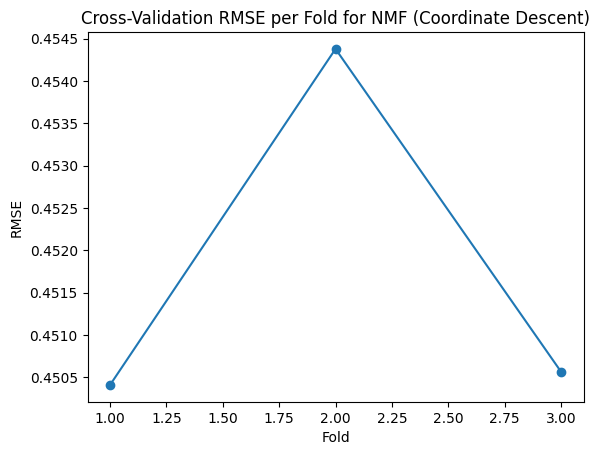

In [121]:
def calculate_rmse(true_matrix, predicted_matrix):
    mask = true_matrix > 0
    masked_true = true_matrix[mask]
    masked_predicted = predicted_matrix[mask]

    return np.sqrt(mean_squared_error(masked_true, masked_predicted))


param_grid = {
    'n_components': [10, 20, 30],
    'alpha_W': [0.01, 0.1, 1.0],
    'alpha_H': [0.01, 0.1, 1.0]
}

kf = KFold(n_splits=3, shuffle=True, random_state=69)
cv_results = []

for train_index, test_index in kf.split(ratings_matrix_normalized):
    train_matrix, test_matrix = ratings_matrix_normalized[train_index], ratings_matrix_normalized[test_index]

    best_rmse = float('inf')
    best_params = None

    for n_components in param_grid['n_components']:
        for alpha_W in param_grid['alpha_W']:
            for alpha_H in param_grid['alpha_H']:
                nmf = NMF(n_components=n_components, random_state=420, solver='cd', alpha_W=alpha_W,
                          alpha_H=alpha_H, max_iter=750)

                W_train = nmf.fit_transform(train_matrix)  # (n_train_users, n_components)
                H = nmf.components_  # (n_components, n_items)

                W_test = np.linalg.lstsq(H.T, test_matrix.T, rcond=None)[0].T  # (n_test_users, n_components)

                predicted_matrix = W_test @ H  # (n_test_users, n_items)

                rmse = calculate_rmse(test_matrix, predicted_matrix)

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = {
                        'n_components': n_components,
                        'alpha_W': alpha_W,
                        'alpha_H': alpha_H
                    }

    print(f'Best parameters for current fold: {best_params}, RMSE: {best_rmse:.4f}')
    cv_results.append(best_rmse)

average_rmse = np.mean(cv_results)
print(f'Average RMSE across 3 folds: {average_rmse:.4f}')

folds = range(1, 4)
plt.plot(folds, cv_results, marker='o')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('Cross-Validation RMSE per Fold for NMF (Coordinate Descent)')
plt.show()

Our implementation `MatrixFactorizationSGD` outperforms scikit-learn in this task by quite a lot. The most obvious reason for that is that scikit-learn's NMF does not incorporate the bias terms $\mu, b_u, b_i$. It only decomposes the user-item matrix into the product of two matrices. This lack of biases makes the predictions less accurate.

Our also Implementation benefits from using SGD with an adaptive learning rate, which may converge more effectively compared to the coordinate descent used by scikit-learn's NMF. We also handle sparsity explicitly by updating only observed values, whereas NMF might over-penalize missing values, which further affects its performance.

# References
Harper, F. M., & Konstan, J. A. (2015). *The MovieLens Datasets: History and Context*. ACM Transactions on Interactive Intelligent Systems (TiiS), 5(4), Article 19. DOI: [10.1145/2827872](http://dx.doi.org/10.1145/2827872)
